# Import Libraries

In [2]:
 !pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [3]:
import numpy as np
import pandas as pd
import re
import nltk
import torch
import matplotlib.pyplot as plt

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments
)
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from transformers import DataCollatorWithPadding

# Download stopwords if necessary
nltk.download('stopwords')

# Enable inline plotting (if running in a Jupyter Notebook)
%matplotlib inline

pd.set_option("display.max_colwidth", None)  # Set to None to display all text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#Load Datasets

In [6]:
# Load the pickle file
test = pd.read_pickle("subset_news.pkl")

# Create DataFrame
test_df = pd.DataFrame({
    'New_names': test['New_names'],
    'ESG_results': test['ESG_results'],
    'Date': test['Date'],
    'Label': test['Label'],
    'Source': test['Source'],
    'text': test['Articles']
})

In [7]:
# Function to compare lengths
def check_length_match(row):
    return len(row["Label"]) == len(row["text"])

# Apply the function
test_df["length_match"] = test_df.apply(check_length_match, axis=1)

# Print mismatches
print(test_df[test_df["length_match"] == False])  # Show rows where lengths don't match

# Summary statistics
print(test_df["length_match"].value_counts())  # Count how many match vs. don't match

# Expand the DataFrame while keeping "New_names" (company names)
expanded_df = test_df.explode(["text", "Label"])[["New_names", "text", "Label"]]

# Reset index for cleanliness
expanded_df = expanded_df.reset_index(drop=True)

# Display a sample
print(expanded_df.head())

Empty DataFrame
Columns: [New_names, ESG_results, Date, Label, Source, text, length_match]
Index: []
length_match
True    5
Name: count, dtype: int64
  New_names  \
0       eni   
1       eni   
2       eni   
3       eni   
4       eni   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [8]:
expanded_df['extracted_text'] = expanded_df['text'].apply(lambda x: x.get('description', '') if isinstance(x, dict) else str(x))

In [9]:
expanded_df.head()

,New_names,text,Label,extracted_text
0,eni,"{'source': {'id': 'reuters', 'name': 'Reuters'}, 'author': 'Libby George', 'title': 'Don't neglect to pay the middleman: How Shell and Eni ended up on trial', 'description': 'LONDON (Reuters) - Seven years ago, two middlemen launched civil lawsuits to seek payment for helping arrange a $1.3 billion oil deal in Nigeria.', 'url': 'https://www.reuters.com/article/us-eni-shell-nigeria-corruption/dont-neglect-to-pay-the-middleman-how-shell-and-eni-ended-up-on-trial-idUSKCN1IL0XH', 'urlToImage': 'https://s2.reutersmedia.net/resources/r/?m=02&d=20180520&t=2&i=1264250870&w=1200&r=LYNXNPEE4J0SF', 'publishedAt': '2018-05-20T23:36:20Z', 'content': 'LONDON (Reuters) - Seven years ago, two middlemen launched civil lawsuits to seek payment for helping arrange a $1.3 billion oil deal in Nigeria. Now, nine current and former executives or contractor… [+4475 chars]'}",Social,"LONDON (Reuters) - Seven years ago, two middlemen launched civil lawsuits to seek payment for helping arrange a $1.3 billion oil deal in Nigeria."
1,eni,"{'source': {'id': 'reuters', 'name': 'Reuters'}, 'author': 'Alasdair Pal', 'title': 'Ferrari and Ray-Ban deemed a safer bet than Italian government bonds', 'description': 'LONDON (Reuters) - Italy's luxury carmaker Ferrari and Exor, the owners of Juventus football club, are among a host of companies that can now borrow money more cheaply than the country's crisis-hit government.', 'url': 'https://www.reuters.com/article/us-italy-markets-corporates/ferrari-and-ray-ban-deemed-a-safer-bet-than-italian-government-bonds-idUSKCN1IW2G8', 'urlToImage': 'https://s3.reutersmedia.net/resources/r/?m=02&d=20180531&t=2&i=1267880641&w=1200&r=LYNXNPEE4U1PM', 'publishedAt': '2018-05-31T16:52:16Z', 'content': 'LONDON (Reuters) - Italy’s luxury carmaker Ferrari and Exor, the owners of Juventus football club, are among a host of companies that can now borrow money more cheaply than the country’s crisis-hit g… [+4413 chars]'}",Social,"LONDON (Reuters) - Italy's luxury carmaker Ferrari and Exor, the owners of Juventus football club, are among a host of companies that can now borrow money more cheaply than the country's crisis-hit government."
2,eni,"{'source': {'id': 'the-wall-street-journal', 'name': 'The Wall Street Journal'}, 'author': 'Rory Jones, Sarah Kent, Bradley Olson', 'title': 'The Wall Street Journal: Big Oil closer to tapping Mediterranean gas bounty', 'description': 'Big oil companies are pushing into Mediterranean waters off Israel, Lebanon and Egypt after years of U.S. diplomacy helped break open a political logjam around giant Middle Eastern natural-gas discoveries.', 'url': 'https://www.wsj.com/articles/mediterranean-gas-bounty-suddenly-seems-within-big-oils-reach/', 'urlToImage': 'http://s.marketwatch.com/public/resources/MWimages/MW-GF427_oil_ri_ZG_20180314083313.jpg', 'publishedAt': '2018-03-14T11:46:09Z', 'content': 'Big oil companies are pushing into Mediterranean waters off Israel, Lebanon and Egypt after years of U.S. diplomacy helped break open a political logjam around giant Middle Eastern natural-gas discov… [+1483 chars]'}",Social,"Big oil companies are pushing into Mediterranean waters off Israel, Lebanon and Egypt after years of U.S. diplomacy helped break open a political logjam around giant Middle Eastern natural-gas discoveries."
3,eni,"{'source': {'id': 'reuters', 'name': 'Reuters'}, 'author': 'Corina Pons', 'title': 'Exclusive: Venezuela signs oil deals similar to ones rolled back under Chavez - document', 'description': 'Venezuela has agreed to hand over at least seven oil fields to little-known companies that will be paid to boost output through contracts similar to ones rolled back under late socialist leader Hugo Chavez, according to two sources and an internal document.', 'url': 'https://www.reuters.com/article/us-venezuela-oil-exclusive/exclusive-venezuela-signs-oil-deals-similar-to-ones-rolled-back-under-chavez-document-idUSKCN1LQ2FQ', 'urlToImage': 'https:

In [10]:
climate_related_df = expanded_df[expanded_df['Label'] == 'Environmental'].drop('text', axis=1)  # filter out climate related text by selecting only Environmental Labels

In [11]:
climate_related_df.head()

,New_names,Label,extracted_text
7,eni,Environmental,"Eni SpA's unit in the Republic of Congo will sponsor a $30 million research center that will search for oil and renewable energy, government spokesman Thierry Moungalla said."
15,eni,Environmental,"Oil companies such as BP and Eni are pouring hundreds of millions of dollars into supercomputers, part of a larger digital arms race among energy companies to produce fossil fuels more cheaply and efficiently."
18,eni,Environmental,European natural gas traders stand to lose about $1 billion in sales to Ukraine.
21,eni,Environmental,"Big Oil is under pressure, unloved and on sale."
22,eni,Environmental,Oil company bosses will travel to the Vatican next week to discuss climate change with Pope Francis.


In [12]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

climate_related_df['extracted_text'] = climate_related_df['extracted_text'].astype(str) # convert extracted_text to string to prevent none type error
climate_related_df['clean_text'] = climate_related_df['extracted_text'].apply(normalize_document) # apply function to preprocess extracted_text

In [13]:
climate_related_df.head()

,New_names,Label,extracted_text,clean_text
7,eni,Environmental,"Eni SpA's unit in the Republic of Congo will sponsor a $30 million research center that will search for oil and renewable energy, government spokesman Thierry Moungalla said.",eni spas unit republic congo sponsor million research center search oil renewable energy government spokesman thierry moungalla said
15,eni,Environmental,"Oil companies such as BP and Eni are pouring hundreds of millions of dollars into supercomputers, part of a larger digital arms race among energy companies to produce fossil fuels more cheaply and efficiently.",oil companies bp eni pouring hundreds millions dollars supercomputers part larger digital arms race among energy companies produce fossil fuels cheaply efficiently
18,eni,Environmental,European natural gas traders stand to lose about $1 billion in sales to Ukraine.,european natural gas traders stand lose billion sales ukraine
21,eni,Environmental,"Big Oil is under pressure, unloved and on sale.",big oil pressure unloved sale
22,eni,Environmental,Oil company bosses will travel to the Vatican next week to discuss climate change with Pope Francis.,oil company bosses travel vatican next week discuss climate change pope francis


# Train Climate Classifers Models - Using Word Embeddings from Pretrained Model

##Prepare the data for training and Testing

In [14]:
#Datasets used to train the pretrained model
splits = {'train': 'data/train-00000-of-00001-4b831beb8839bf3e.parquet', 'test': 'data/test-00000-of-00001-87f8706e009e9b75.parquet'}
train_df = pd.read_parquet("hf://datasets/climatebert/climate_detection/" + splits["train"])
test_df = pd.read_parquet("hf://datasets/climatebert/climate_detection/" + splits["test"])

In [15]:
train_df.head()

,text,label
0,"− Scope 3: Optional scope that includes indirect emissions associated with the goods and services supply chain produced outside the organization. Included are emissions from the transport of products from our logistics centres to stores (downstream) performed by external logistics operators (air, land and sea transport) as well as the emissions associated with electricity consumption in franchise stores.",1
1,"The Group is not aware of any noise pollution that could negatively impact the environment, nor is it aware of any impact on biodiversity. With regards to land use, the Group is only a commercial user, and the Group is not aware of any local constraints with regards to water supply. The Group does not believe that it is at risk with regards to climate change in the near-or mid-term.",1
2,"Global climate change could exacerbate certain of the threats facing our business, including the frequency and severity of weather-related events referred to in Performance of critical infrastructure in this section 9. In addition, increases in energy prices are partly influenced by government policies to address climate change which, combined with a growing data demand that increases our energy requirements, could increase our energy costs beyond our current expectations.",1
3,"Setting an investment horizon is part and parcel of our policy of focusing on the long term and helping clients to build capital. Both financial and non-financial aspects play a role in measuring investment returns. Even if we make a successful investment in a mining company today, the same company may nonetheless cause damage to the environment tomorrow, and thus be compelled to make substantial provisions for improving its waste-processing activities and paying fines. As an asset manager that focuses on the long-term prospects, we can’t ignore the non-financial aspects.",1
4,"A material portion of this network is still relatively immature and there are risks that may develop over time. For example, it is possible that branches may not be able to sustain the level of revenue or profitability that they currently achieve (or that it is forecasted that they will achieve).",0


In [16]:
test_df.head()

,text,label
0,"Sustainable strategy ‘red lines’ For our sustainable strategy range, we incorporate a series of proprietary ‘red lines’ in order to ensure the poorest- performing companies from an ESG perspective are not eligible for investment.",1
1,"Verizon’s environmental, health and safety management system provides a framework for identifying, controlling, and reducing the risks associated with the environments in which we operate. Besides regular management system assessments, internal and third-party compliance audits and inspections are performed annually at hundreds of facilities worldwide. The goal of these assessments is to identify and correct site-specific issues, and to educate and empower facility managers and supervisors to implement corrective actions. Verizon’s environment, health and safety efforts are directed and supported by experienced experts around the world that support our operations and facilities.",1
2,"In 2019, the Company closed a series of transactions related to the sale of its Canadian fossil fuel-based electricity generation business. A transaction with Heartland Generation Ltd., an affiliate of Energy Capital Partners, included the sale of 10 partly or fully owned natural gas-fired and coal-fired electricity generation assets located in Alberta and British Columbia. In two other separate transactions, the Company sold its 50 per cent ownership interest in the Cory Cogeneration Station to SaskPower International and its 50 per cent ownership interest in Brighton Beach Power to Ontario Power Generation.",1
3,"In December 2020, the AUC approved the Electricity Distribution and Natural Gas Distribution requests to defer the compulsory distribution rate increases which would normally come into effect on January 1, 2021 for both businesses. The rate relief was requested to defer significant distribution rate increases which would be passed onto end use customers due to the formulaic approach of rate calculations under the AUC PBR mechanism. Electricity Distribution and Natural Gas Distribution cited the current economic situation in Alberta, including the hardships faced by some end use customers due to the COVID-19 pandemic, as rationale to proceed with these interim rates. Electricity Distribution and Natural Gas Distribution are to file an application by March 1, 2021, outlining the duration of the rate freeze and collection timelines, expected deferral values including carrying costs and anticipated impacts to customers.",1
4,"Finally, there is a reputational risk linked to the possibility that oil companies may be perceived by institutions and the general public as the entities mainly responsible of the climate change. This could possibly make Eni’s shares less attractive to investment funds and individual investors who assess the risk profile of companies against their environmental and social footprint when making investment decisions.",1


In [17]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english') # initialize the stop word list

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)  # re.I ignores cases, re.A matches only ASCII characters)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [18]:
train_df['clean_text'] = normalize_corpus(train_df['text'])
train_df.drop('text', axis=1, inplace=True)

test_df['clean_text'] = normalize_corpus(test_df['text'])
test_df.drop('text', axis=1, inplace=True)

In [19]:
test_df.head()

,label,clean_text
0,1,sustainable strategy red lines sustainable strategy range incorporate series proprietary red lines order ensure poorest performing companies esg perspective eligible investment
1,1,verizons environmental health safety management system provides framework identifying controlling reducing risks associated environments operate besides regular management system assessments internal thirdparty compliance audits inspections performed annually hundreds facilities worldwide goal assessments identify correct sitespecific issues educate empower facility managers supervisors implement corrective actions verizons environment health safety efforts directed supported experienced experts around world support operations facilities
2,1,company closed series transactions related sale canadian fossil fuelbased electricity generation business transaction heartland generation ltd affiliate energy capital partners included sale partly fully owned natural gasfired coalfired electricity generation assets located alberta british columbia two separate transactions company sold per cent ownership interest cory cogeneration station saskpower international per cent ownership interest brighton beach power ontario power generation
3,1,december auc approved electricity distribution natural gas distribution requests defer compulsory distribution rate increases would normally come effect january businesses rate relief requested defer significant distribution rate increases would passed onto end use customers due formulaic approach rate calculations auc pbr mechanism electricity distribution natural gas distribution cited current economic situation alberta including hardships faced end use customers due covid pandemic rationale proceed interim rates electricity distribution natural gas distribution file application march outlining duration rate freeze collection timelines expected deferral values including carrying costs anticipated impacts customers
4,1,finally reputational risk linked possibility oil companies may perceived institutions general public entities mainly responsible climate change could possibly make enis shares less attractive investment funds individual investors assess risk profile companies environmental social footprint making investment decisions


In [20]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df["clean_text"], train_df["label"], test_size=0.2, random_state=42
)

print('Training Text Shape:', train_texts.shape)
print('Validation Text Shape:', val_texts.shape)

Training Text Shape: (1040,)
Validation Text Shape: (260,)


In [21]:
from transformers import AutoTokenizer, DataCollatorWithPadding
from datasets import Dataset

# Load the ClimateBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("climatebert/distilroberta-base-climate-f")

# Preprocessing function
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True)

# Create Hugging Face Datasets from your splits
train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_dataset = Dataset.from_dict({"text": val_texts, "label": val_labels})
test_dataset = Dataset.from_dict({"text": test_df["clean_text"], "label": test_df["label"]} )

# Apply preprocessing to datasets
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_val = val_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

# Data collator for padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.15M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Map:   0%|          | 0/1040 [00:00<?, ? examples/s]

Map:   0%|          | 0/260 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

##Random Forest + ClimateBERT Embeddings

In [ ]:
# api_key = "8ec8bc19703be8b194740cb432b69daca034395b" # might be needeed

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, log_loss
from transformers import AutoTokenizer, AutoModel
import torch

# Load tokenizer and model (Use AutoModel to access hidden states)
model_name = "climatebert/distilroberta-base-climate-f"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Function to get embeddings
def get_embeddings(texts, batch_size=32):
    """Gets ClimateBERT embeddings for a list of texts in batches."""
    all_embeddings = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set model to evaluation mode

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=512).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # [CLS] token
            all_embeddings.extend(embeddings)

    return np.array(all_embeddings)

# Get embeddings for train, validation, and test data
train_embeddings = get_embeddings(train_texts.tolist(), batch_size=32)
val_embeddings = get_embeddings(val_texts.tolist(), batch_size=32)
test_embeddings = get_embeddings(test_df["clean_text"].tolist(), batch_size=32)

# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(val_embeddings, val_labels)

# Train best model on combined train + validation data
best_rf_model = grid_search.best_estimator_
train_val_embeddings = np.concatenate([train_embeddings, val_embeddings])
train_val_labels = np.concatenate([train_labels, val_labels])
best_rf_model.fit(train_val_embeddings, train_val_labels)

# Evaluate on test set
test_preds = best_rf_model.predict(test_embeddings)
test_probs = best_rf_model.predict_proba(test_embeddings)[:, 1]

print("\nTest Results:")
print(classification_report(test_df["label"], test_preds))
print("Test Accuracy:", accuracy_score(test_df["label"], test_preds))
print("Test AUC:", roc_auc_score(test_df["label"], test_probs))
print("Test Loss:", log_loss(test_df["label"], test_probs))


config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-f and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Test Results:
              precision    recall  f1-score   support

           0       0.71      0.44      0.54        80
           1       0.87      0.96      0.91       320

    accuracy                           0.85       400
   macro avg       0.79      0.70      0.73       400
weighted avg       0.84      0.85      0.84       400

Test Accuracy: 0.8525
Test AUC: 0.9008984374999999
Test Loss: 0.3586564326531144


##Logistic Regression + ClimateBERT Embeddings

In [22]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, log_loss
from transformers import AutoTokenizer, AutoModel  # Use AutoModel (not classifier model)
import torch

# Load tokenizer and model (Use AutoModel to access hidden states)
model_name = "climatebert/distilroberta-base-climate-f"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Function to get embeddings
def get_embeddings(texts, batch_size=32):
    """Gets ClimateBERT embeddings for a list of texts in batches."""
    all_embeddings = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set model to evaluation mode

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=512).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # [CLS] token
            all_embeddings.extend(embeddings)

    return np.array(all_embeddings)

# Get embeddings for train, validation, and test data
train_embeddings = get_embeddings(train_texts.tolist(), batch_size=32)
val_embeddings = get_embeddings(val_texts.tolist(), batch_size=32)
test_embeddings = get_embeddings(test_df["clean_text"].tolist(), batch_size=32)

# Hyperparameter tuning
param_grid = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}
grid_search = GridSearchCV(LogisticRegression(max_iter=1000, solver='liblinear'), param_grid, cv=5, scoring='accuracy')
grid_search.fit(val_embeddings, val_labels)

# Train best model on combined train + validation data
best_lr_model = grid_search.best_estimator_
train_val_embeddings = np.concatenate([train_embeddings, val_embeddings])
train_val_labels = np.concatenate([train_labels, val_labels])
best_lr_model.fit(train_val_embeddings, train_val_labels)

# Evaluate on test set
test_preds = best_lr_model.predict(test_embeddings)
test_probs = best_lr_model.predict_proba(test_embeddings)[:, 1]

print("\nTest Results:")
print(classification_report(test_df["label"], test_preds))
print("Test Accuracy:", accuracy_score(test_df["label"], test_preds))
print("Test AUC:", roc_auc_score(test_df["label"], test_probs))
print("Test Loss:", log_loss(test_df["label"], test_probs))


config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-f and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Test Results:
              precision    recall  f1-score   support

           0       0.70      0.85      0.77        80
           1       0.96      0.91      0.93       320

    accuracy                           0.90       400
   macro avg       0.83      0.88      0.85       400
weighted avg       0.91      0.90      0.90       400

Test Accuracy: 0.8975
Test AUC: 0.9401171875
Test Loss: 0.2994687829413636


# Use Logistic Regression Climate Classifier to Classify text  (climate related or not)

In [23]:
# Get ClimateBERT embeddings for the climate-related text
climate_text_embeddings = get_embeddings(climate_related_df["clean_text"].tolist(), batch_size=32)


In [24]:
import joblib

# save the trained Logistic Regression model
joblib.dump(best_lr_model, "logistic_regression_climatebert.pkl")

# Load the trained Logistic Regression model
best_lr_model = joblib.load("logistic_regression_climatebert.pkl")  # Ensure the correct file path


In [25]:
# Make predictions
climate_related_df["predicted_climate_relevance"] = best_lr_model.predict(climate_text_embeddings)

# Get prediction probabilities (for confidence scores)
climate_related_df["prediction_probability"] = best_lr_model.predict_proba(climate_text_embeddings)[:, 1]


In [26]:
climate_related_df.head()

,New_names,Label,extracted_text,clean_text,predicted_climate_relevance,prediction_probability
7,eni,Environmental,"Eni SpA's unit in the Republic of Congo will sponsor a $30 million research center that will search for oil and renewable energy, government spokesman Thierry Moungalla said.",eni spas unit republic congo sponsor million research center search oil renewable energy government spokesman thierry moungalla said,0,0.349470
15,eni,Environmental,"Oil companies such as BP and Eni are pouring hundreds of millions of dollars into supercomputers, part of a larger digital arms race among energy companies to produce fossil fuels more cheaply and efficiently.",oil companies bp eni pouring hundreds millions dollars supercomputers part larger digital arms race among energy companies produce fossil fuels cheaply efficiently,1,0.738140
18,eni,Environmental,European natural gas traders stand to lose about $1 billion in sales to Ukraine.,european natural gas traders stand lose billion sales ukraine,0,0.217773
21,eni,Environmental,"Big Oil is under pressure, unloved and on sale.",big oil pressure unloved sale,1,0.810386
22,eni,Environmental,Oil company bosses will travel to the Vatican next week to discuss climate change with Pope Francis.,oil company bosses travel vatican next week discuss climate change pope francis,0,0.178499


In [35]:
# Extraxt text predicted by Model to be Climate related
climate_df = climate_related_df[climate_related_df['predicted_climate_relevance'] == 1]

In [36]:
climate_df.head()

,New_names,Label,extracted_text,clean_text,predicted_climate_relevance,prediction_probability
15,eni,Environmental,"Oil companies such as BP and Eni are pouring hundreds of millions of dollars into supercomputers, part of a larger digital arms race among energy companies to produce fossil fuels more cheaply and efficiently.",oil companies bp eni pouring hundreds millions dollars supercomputers part larger digital arms race among energy companies produce fossil fuels cheaply efficiently,1,0.738140
21,eni,Environmental,"Big Oil is under pressure, unloved and on sale.",big oil pressure unloved sale,1,0.810386
25,eni,Environmental,Statoil ASA gave the final go-ahead to a flagship Arctic oil project after slashing costs by half.,statoil asa gave final goahead flagship arctic oil project slashing costs half,1,0.920130
38,eni,Environmental,Anadarko Petroleum Corp. is in talks to sate China’s increasing appetite for liquefied natural gas from its planned development in Mozambique.,anadarko petroleum corp talks sate chinas increasing appetite liquefied natural gas planned development mozambique,1,0.960508
42,eni,Environmental,Egypt has been hit by energy shortages and power blackouts that have plunged homes and businesses into darkness. Now that could be something of the past.,egypt hit energy shortages power blackouts plunged homes businesses darkness could something past,1,0.535478


# Specificity Analysis

In [48]:
from transformers import pipeline

# Load pretrained ClimateBERT specificity model
model_name = "climatebert/distilroberta-base-climate-specificity"
classifier = pipeline("text-classification", model=model_name)

# Apply classifier to your dataset
climate_df["spec_label"] = climate_df["extracted_text"].apply(
    lambda text: classifier(text, truncation=True, max_length=512)[0]["label"]
)

# Check label distribution
print(climate_df["spec_label"].value_counts())

# Map to binary format: spec → 1 (yes), non → 0 (no)
label_map = {"spec": 1, "non": 0}
climate_df["specific"] = climate_df["spec_label"].map(label_map)

climate_df["specific"] = climate_df["specific"].map({1: "yes", 0: "no"})

climate_df.drop('spec_label', axis=1, inplace=True)

# # Save the labeled dataset
# climate_df.to_csv("specificity_labeled_texts.csv", index=False)

climate_df.head()


Device set to use cuda:0


spec_label
spec    1694
non     1437
Name: count, dtype: int64


<ipython-input-48-fd0a8e060915>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  climate_df["spec_label"] = climate_df["extracted_text"].apply(
<ipython-input-48-fd0a8e060915>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  climate_df["specific"] = climate_df["spec_label"].map(label_map)
<ipython-input-48-fd0a8e060915>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

,New_names,Label,extracted_text,clean_text,predicted_climate_relevance,prediction_probability,specific
15,eni,Environmental,"Oil companies such as BP and Eni are pouring hundreds of millions of dollars into supercomputers, part of a larger digital arms race among energy companies to produce fossil fuels more cheaply and efficiently.",oil companies bp eni pouring hundreds millions dollars supercomputers part larger digital arms race among energy companies produce fossil fuels cheaply efficiently,1,0.738140,yes
21,eni,Environmental,"Big Oil is under pressure, unloved and on sale.",big oil pressure unloved sale,1,0.810386,no
25,eni,Environmental,Statoil ASA gave the final go-ahead to a flagship Arctic oil project after slashing costs by half.,statoil asa gave final goahead flagship arctic oil project slashing costs half,1,0.920130,yes
38,eni,Environmental,Anadarko Petroleum Corp. is in talks to sate China’s increasing appetite for liquefied natural gas from its planned development in Mozambique.,anadarko petroleum corp talks sate chinas increasing appetite liquefied natural gas planned development mozambique,1,0.960508,yes
42,eni,Environmental,Egypt has been hit by energy shortages and power blackouts that have plunged homes and businesses into darkness. Now that could be something of the past.,egypt hit energy shortages power blackouts plunged homes businesses darkness could something past,1,0.535478,no


# Sentiment Analysis

##ClimateBERT sentiment model (Pretrained)

In [49]:
# Load ClimateBERT sentiment model
model_name = "climatebert/distilroberta-base-climate-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
clm_sen_model = AutoModelForSequenceClassification.from_pretrained(model_name)

clm_sen_embeddings = get_embeddings(test_df["clean_text"].tolist(), batch_size=32)

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/4.48k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/947 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

In [ ]:
# # Function to get sentiment predictions
# def get_sentiment_predictions(texts, batch_size=32):
#     all_predictions = []
#     for i in range(0, len(texts), batch_size):
#         batch = texts[i:i + batch_size]
#         inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=512)
#         with torch.no_grad():
#             outputs = clm_sen_model(**inputs)

#         # Apply softmax to get probabilities
#         logits = outputs.logits
#         probs = torch.nn.functional.softmax(logits, dim=-1)

#         # Get the predicted class (0 or 1, depending on your model's class labels)
#         predictions = torch.argmax(probs, dim=-1).cpu().numpy()
#         all_predictions.extend(predictions)

#     return all_predictions

# # Classify sentiments for climate_df['clean_text']
# sentiments = get_sentiment_predictions(climate_df['clean_text'].tolist(), batch_size=32)

# # add the sentiment predictions to the DataFrame
# climate_df['sentiment'] = sentiments

# # Check the DataFrame with the sentiment labels
# print(climate_df[['clean_text', 'sentiment']].head())

In [51]:
# Function to get sentiment predictions
def get_sentiment_predictions(texts, batch_size=32):
    all_predictions = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=512)
        with torch.no_grad():
            outputs = clm_sen_model(**inputs)

        # Apply softmax to get probabilities
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=-1)

        # Get the predicted class (0 or 1, depending on your model's class labels)
        predictions = torch.argmax(probs, dim=-1).cpu().numpy()
        all_predictions.extend(predictions)

    return all_predictions

# Classify sentiments for climate_df['clean_text']
sentiments = get_sentiment_predictions(climate_df['extracted_text'].tolist(), batch_size=32)

# Optionally, add the sentiment predictions to the DataFrame
climate_df['cb_sentiment'] = sentiments

# Check the DataFrame with the sentiment labels
print(climate_df[['extracted_text', 'cb_sentiment']].head())

                                                                                                                                                                                                       extracted_text  \
15  Oil companies such as BP and Eni are pouring hundreds of millions of dollars into supercomputers, part of a larger digital arms race among energy companies to produce fossil fuels more cheaply and efficiently.   
21                                                                                                                                                                    Big Oil is under pressure, unloved and on sale.   
25                                                                                                                 Statoil ASA gave the final go-ahead to a flagship Arctic oil project after slashing costs by half.   
38                                                                     Anadarko Petroleum Corp. is in talks to sate China’s increasi

<ipython-input-51-e459645bc797>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  climate_df['cb_sentiment'] = sentiments


In [53]:
# Mapping from numerical label to sentiment category
sentiment_mapping = {
    0: 'risk',
    1: 'neutral',
    2: 'opportunity'
}

# Apply the mapping to get human-readable sentiment labels
climate_df['sentiment_label'] = climate_df['cb_sentiment'].map(sentiment_mapping)

<ipython-input-53-64bb6834bf48>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  climate_df['sentiment_label'] = climate_df['cb_sentiment'].map(sentiment_mapping)


In [54]:
climate_df.head()

,New_names,Label,extracted_text,clean_text,predicted_climate_relevance,prediction_probability,specific,cb_sentiment,sentiment_label
15,eni,Environmental,"Oil companies such as BP and Eni are pouring hundreds of millions of dollars into supercomputers, part of a larger digital arms race among energy companies to produce fossil fuels more cheaply and efficiently.",oil companies bp eni pouring hundreds millions dollars supercomputers part larger digital arms race among energy companies produce fossil fuels cheaply efficiently,1,0.738140,yes,0,risk
21,eni,Environmental,"Big Oil is under pressure, unloved and on sale.",big oil pressure unloved sale,1,0.810386,no,2,opportunity
25,eni,Environmental,Statoil ASA gave the final go-ahead to a flagship Arctic oil project after slashing costs by half.,statoil asa gave final goahead flagship arctic oil project slashing costs half,1,0.920130,yes,0,risk
38,eni,Environmental,Anadarko Petroleum Corp. is in talks to sate China’s increasing appetite for liquefied natural gas from its planned development in Mozambique.,anadarko petroleum corp talks sate chinas increasing appetite liquefied natural gas planned development mozambique,1,0.960508,yes,1,neutral
42,eni,Environmental,Egypt has been hit by energy shortages and power blackouts that have plunged homes and businesses into darkness. Now that could be something of the past.,egypt hit energy shortages power blackouts plunged homes businesses darkness could something past,1,0.535478,no,2,opportunity


## Rule-based Aspect Extraction

In [55]:
climate_aspect_keywords = {
    "renewables": [
        "renewable", "solar", "wind", "hydro", "clean energy", "green energy",
        "photovoltaic", "geothermal", "biomass", "offshore wind", "onshore wind",
        "green hydrogen", "electrification"
    ],
    "fossil_fuels": [
        "oil", "gas", "coal", "fossil fuels", "drilling", "extraction", "petroleum",
        "natural gas", "fracking", "offshore drilling", "oil sands"
    ],
    "emissions": [
        "carbon", "emissions", "co2", "carbon dioxide", "net zero", "carbon neutral",
        "greenhouse gases", "methane", "carbon capture", "ghg", "emission cuts"
    ],
    "policy": [
        "regulation", "carbon tax", "emissions trading", "climate policy",
        "agreement", "paris accord", "environmental law", "legislation",
        "cop26", "policy change", "climate regulation"
    ],
    "climate_transition": [
        "transition", "decarbonization", "climate action", "climate strategy",
        "sustainability", "net-zero targets", "climate goals", "transition risk"
    ],
    "energy_efficiency": [
        "efficiency", "supercomputers", "energy efficiency", "smart grid",
        "digital energy", "building efficiency", "industrial efficiency",
        "retrofitting", "insulation"
    ],
    "climate_risk": [
        "climate risk", "transition risk", "physical risk", "climate-related risks",
        "risk disclosure", "climate threat"
    ],
    "finance_investment": [
        "green bonds", "sustainable finance", "climate finance", "green investment",
        "esg", "carbon credit", "divestment", "stranded assets", "climate disclosure"
    ],
    "transportation": [
        "electric vehicles", "ev", "battery storage", "charging stations",
        "vehicle emissions", "hybrid", "sustainable transport",
        "biofuels", "clean transport"
    ],
    "climate_impact": [
        "climate change", "global warming", "rising temperatures",
        "climate crisis", "warming planet", "sea level rise", "extreme weather",
        "melting glaciers", "heatwaves", "drought", "flooding"
    ],
    "climate_innovation": [
        "innovation", "green tech", "carbon removal", "direct air capture",
        "climate technology", "clean technology", "energy storage", "green startups"
    ]
}


In [56]:
# Function to tag climate-related aspects in each text
def tag_aspects(text, aspect_dict):
    aspects_found = set()
    for aspect, keywords in aspect_dict.items():
        for kw in keywords:
            if kw in text:
                aspects_found.add(aspect)
                break
    return list(aspects_found)

# Apply the function to tag aspects in clean_text
climate_df["detected_aspects"] = climate_df["clean_text"].apply(lambda x: tag_aspects(x, climate_aspect_keywords))
climate_df[["clean_text", "detected_aspects"]]

<ipython-input-56-54fc2e6122a8>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  climate_df["detected_aspects"] = climate_df["clean_text"].apply(lambda x: tag_aspects(x, climate_aspect_keywords))


,clean_text,detected_aspects
15,oil companies bp eni pouring hundreds millions dollars supercomputers part larger digital arms race among energy companies produce fossil fuels cheaply efficiently,"[fossil_fuels, energy_efficiency]"
21,big oil pressure unloved sale,[fossil_fuels]
25,statoil asa gave final goahead flagship arctic oil project slashing costs half,[fossil_fuels]
38,anadarko petroleum corp talks sate chinas increasing appetite liquefied natural gas planned development mozambique,"[transportation, fossil_fuels]"
42,egypt hit energy shortages power blackouts plunged homes businesses darkness could something past,[]
...,...,...
13556,india planning billion incentive programme green hydrogen industry three sources told reuters bid cut emissions become major export player field,"[renewables, emissions]"
13561,good start holy grail decarbonization would entail plugging industry emerging hydrogen economy,"[renewables, emissions, climate_transition]"
13571,cap revenue lack kind incentives offered oil explorers blocking development renewable energy britain say industry officials pressing changes ahead weeks budget,"[renewables, fossil_fuels, transportation]"
13572,billions dollars clean energy incentives poised speed investment american soil putting european unions energy transition risk luring away money talent executives ceraweek energy conference said week,"[renewables, fossil_fuels, climate_risk, climate_transition]"


In [57]:
climate_df['detected_aspects'].apply(lambda x: len(x) == 0).value_counts()


,count
detected_aspects,
False,2848
True,283


283 unidentified aspects might use lemmatization

In [58]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Download WordNet data (if not already downloaded)
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
# Download the 'punkt_tab' and 'averaged_perceptron_tagger_eng' data
nltk.download('punkt_tab') # Download the punkt_tab resource
nltk.download('averaged_perceptron_tagger_eng')  # This is the missing resource

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to get the WordNet POS tag
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)  # Default to noun if not found

# Function to lemmatize text
def lemmatize_text(text):
    tokens = nltk.word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]
    return ' '.join(lemmas)

# Apply lemmatization to 'clean_text' column
climate_df['lemmatized_text'] = climate_df['clean_text'].apply(lemmatize_text)

# Now use 'lemmatized_text' for aspect detection
climate_df["detected_aspects"] = climate_df["lemmatized_text"].apply(lambda x: tag_aspects(x, climate_aspect_keywords))

# Check for empty aspects again
climate_df['detected_aspects'].apply(lambda x: len(x) == 0).value_counts()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
<ipython-input-58-a70ff2fff16b>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  climate_df['lemmatized_text'] = climate_df['clean_text'].apply(lemmatize_text)
<ipython-input-58-a70ff2fff16b>:35: SettingWithCopyWarning: 
A value is trying to be set 

,count
detected_aspects,
False,2791
True,340


lemmatization does not improve the count of unidentified aspects

## Rule-Based Sentiment with VADER - Sentiment Analysis for Each Aspect.

In [60]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download VADER lexicon (only once needed)
nltk.download('vader_lexicon')

# Initialize the analyzer
sid = SentimentIntensityAnalyzer()

# Function to get sentiment polarity
def get_sentiment(text):
    scores = sid.polarity_scores(text)
    compound = scores['compound']
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment to each row
climate_df['sentiment'] = climate_df['clean_text'].apply(get_sentiment)

# Now map sentiment to each aspect (explode the aspects for cleaner analysis)
exploded = climate_df.explode('detected_aspects')[['New_names', 'clean_text', 'detected_aspects', 'sentiment']]
exploded = exploded.rename(columns={'detected_aspects': 'aspect'})

# Drop rows with no detected aspect
exploded = exploded[exploded['aspect'].notnull()]

# Preview
print(exploded.head())


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


   New_names  \
15       eni   
21       eni   
25       eni   
38       eni   
38       eni   

                                                                                                                                                             clean_text  \
15  oil companies bp eni pouring hundreds millions dollars supercomputers part larger digital arms race among energy companies produce fossil fuels cheaply efficiently   
21                                                                                                                                        big oil pressure unloved sale   
25                                                                                       statoil asa gave final goahead flagship arctic oil project slashing costs half   
38                                                   anadarko petroleum corp talks sate chinas increasing appetite liquefied natural gas planned development mozambique   
38                                              

<ipython-input-60-41aba9dbd8fd>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  climate_df['sentiment'] = climate_df['clean_text'].apply(get_sentiment)


In [61]:
exploded.head(20)

,New_names,clean_text,aspect,sentiment
15,eni,oil companies bp eni pouring hundreds millions dollars supercomputers part larger digital arms race among energy companies produce fossil fuels cheaply efficiently,fossil_fuels,positive
21,eni,big oil pressure unloved sale,fossil_fuels,negative
25,eni,statoil asa gave final goahead flagship arctic oil project slashing costs half,fossil_fuels,negative
38,eni,anadarko petroleum corp talks sate chinas increasing appetite liquefied natural gas planned development mozambique,transportation,positive
38,eni,anadarko petroleum corp talks sate chinas increasing appetite liquefied natural gas planned development mozambique,fossil_fuels,positive
50,eni,milan reuters italian gas grid company snam launched million euro million tender convert car fleet natural gas sign commitment develop gas fuelling stations country,transportation,positive
50,eni,milan reuters italian gas grid company snam launched million euro million tender convert car fleet natural gas sign commitment develop gas fuelling stations country,fossil_fuels,positive
69,eni,egypts government taking unconventional approach toward becoming middle easts next big naturalgas exporter citizens footing bill,fossil_fuels,neutral
72,eni,vatican city reuters environmentalists aid agencies urged executives worlds top oil companies attending vatican conference climate change friday heed pope franciss warnings global warming,fossil_fuels,positive
72,eni,vatican city reuters environmentalists aid agencies urged executives worlds top oil companies attending vatican conference climate change friday heed pope franciss warnings global warming,climate_impact,positive


In [62]:
climate_df.head()

,New_names,Label,extracted_text,clean_text,predicted_climate_relevance,prediction_probability,specific,cb_sentiment,sentiment_label,detected_aspects,lemmatized_text,sentiment
15,eni,Environmental,"Oil companies such as BP and Eni are pouring hundreds of millions of dollars into supercomputers, part of a larger digital arms race among energy companies to produce fossil fuels more cheaply and efficiently.",oil companies bp eni pouring hundreds millions dollars supercomputers part larger digital arms race among energy companies produce fossil fuels cheaply efficiently,1,0.738140,yes,0,risk,[fossil_fuels],oil company bp eni pour hundred million dollar supercomputer part large digital arm race among energy company produce fossil fuel cheaply efficiently,positive
21,eni,Environmental,"Big Oil is under pressure, unloved and on sale.",big oil pressure unloved sale,1,0.810386,no,2,opportunity,[fossil_fuels],big oil pressure unloved sale,negative
25,eni,Environmental,Statoil ASA gave the final go-ahead to a flagship Arctic oil project after slashing costs by half.,statoil asa gave final goahead flagship arctic oil project slashing costs half,1,0.920130,yes,0,risk,[fossil_fuels],statoil asa give final goahead flagship arctic oil project slash cost half,negative
38,eni,Environmental,Anadarko Petroleum Corp. is in talks to sate China’s increasing appetite for liquefied natural gas from its planned development in Mozambique.,anadarko petroleum corp talks sate chinas increasing appetite liquefied natural gas planned development mozambique,1,0.960508,yes,1,neutral,"[transportation, fossil_fuels]",anadarko petroleum corp talk sate china increase appetite liquefy natural gas plan development mozambique,positive
42,eni,Environmental,Egypt has been hit by energy shortages and power blackouts that have plunged homes and businesses into darkness. Now that could be something of the past.,egypt hit energy shortages power blackouts plunged homes businesses darkness could something past,1,0.535478,no,2,opportunity,[],egypt hit energy shortage power blackout plunge home business darkness could something past,negative


## WordCloud of Sentiment Categories

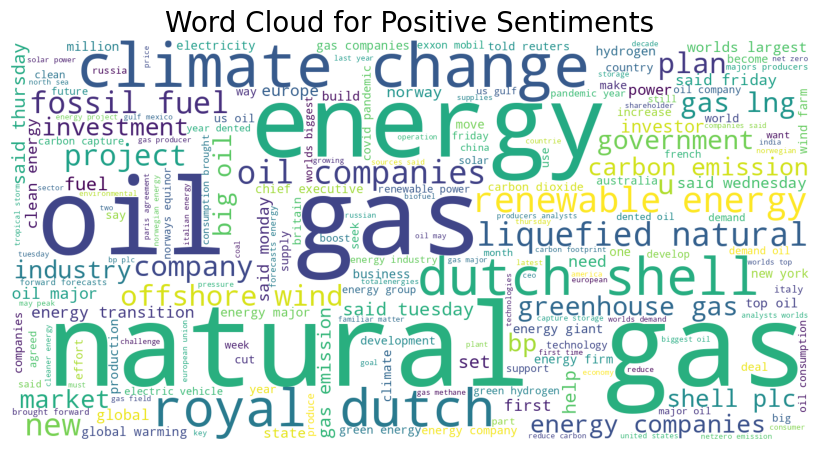

In [63]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Function to create word cloud
def create_wordcloud(text, title):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(width = 1400, height = 700,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(text)

    # Plot the WordCloud image
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(title, fontsize=20)
    plt.show()

# Example: Word cloud for positive sentiment
positive_text = ' '.join(climate_df[climate_df['sentiment'] == 'positive']['clean_text'].astype(str).tolist())
create_wordcloud(positive_text, "Word Cloud for Positive Sentiments")



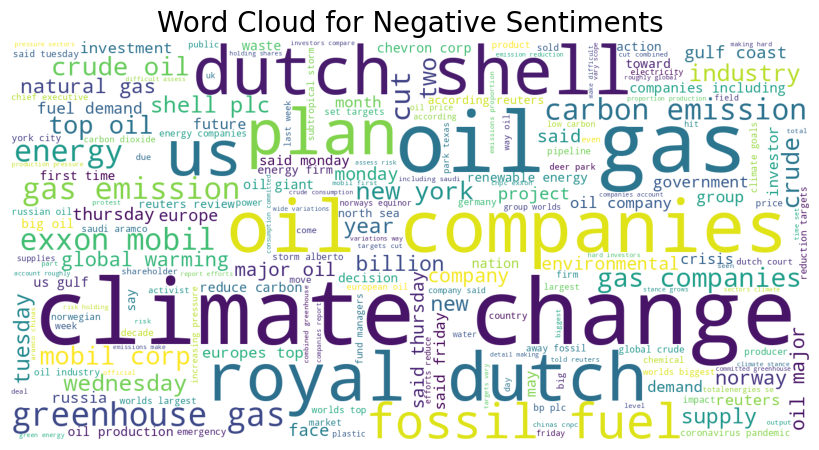

In [64]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Function to create word cloud
def create_wordcloud(text, title):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(width = 1400, height = 700,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(text)

    # Plot the WordCloud image
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(title, fontsize=20)
    plt.show()

# Example: Word cloud for positive sentiment
negative_text = ' '.join(climate_df[climate_df['sentiment'] == 'negative']['clean_text'].astype(str).tolist())
create_wordcloud(negative_text, "Word Cloud for Negative Sentiments")



## Sentiment Distribution Per Aspect

In [66]:
import plotly.express as px
import pandas as pd

# Group by aspect and sentiment, then count
sentiment_counts = exploded.groupby(['aspect', 'sentiment']).size().reset_index(name='counts')

# Create Plotly stacked bar chart
fig = px.bar(sentiment_counts,
             x="counts",
             y="aspect",
             color="sentiment",
             orientation='h',
             color_discrete_map={'negative': '#d62728', 'neutral': '#bdbdbd', 'positive': '#2ca02c'},
             title="Sentiment Distribution per Aspect")

# Customize layout for better aesthetics
fig.update_layout(
    xaxis_title="Number of Texts",
    yaxis_title="Aspect",
    legend_title="Sentiment",
    plot_bgcolor='white',  # Set background color to white
    font=dict(family="Arial", size=12), # Customize font
    barmode='stack',
    yaxis={'categoryorder':'total ascending'}  # Sort y-axis by total count
)

fig.show()

Sentiment Distribution Per Aspect by Company

In [69]:
import plotly.express as px
import pandas as pd

# Group data
sentiment_counts = exploded.groupby(['aspect', 'sentiment', 'New_names']).size().reset_index(name='counts')

# Set default company (first in the list)
default_company = sentiment_counts["New_names"].unique()[0]

# Filter for the default company - Use .loc for index-based selection
filtered_df = sentiment_counts.loc[sentiment_counts["New_names"] == default_company]

# Create initial bar chart using Plotly Express
fig = px.bar(filtered_df,
             x="counts",
             y="aspect",
             color="sentiment",
             orientation='h',
             color_discrete_map={'negative': '#d62728', 'neutral': '#bdbdbd', 'positive': '#2ca02c'},
             title="Sentiment Distribution per Aspect by Company")

# Sort y-axis by total count (preserve same order)
fig.update_layout(yaxis={'categoryorder': 'total ascending'})

# Create dropdown menu buttons - Use .loc for filtering
dropdown_buttons = [
    {
        "label": company,
        "method": "restyle",
        "args": [
            {
                "x": [sentiment_counts.loc[
                          (sentiment_counts["New_names"] == company) & (sentiment_counts["sentiment"] == sentiment),
                          "counts"
                      ].tolist()
                      for sentiment in ['negative', 'neutral', 'positive']
                      ],
                "y": [sentiment_counts.loc[
                          (sentiment_counts["New_names"] == company) & (sentiment_counts["sentiment"] == sentiment),
                          "aspect"
                      ].tolist()
                      for sentiment in ['negative', 'neutral', 'positive']
                      ]
            }
        ]
    }
    for company in sentiment_counts["New_names"].unique()
]

# Add dropdown to layout
fig.update_layout(
    updatemenus=[
        {
            "buttons": dropdown_buttons,
            "direction": "down",
            "showactive": True,
            "x": 0.1,
            "xanchor": "left",
            "y": 1.1,
            "yanchor": "top"
        }
    ],
    xaxis_title=default_company,
    yaxis_title="Aspect",
    legend_title="Sentiment",
    plot_bgcolor='white',
    font=dict(family="Arial", size=12),
    barmode='stack'
)

fig.show()

# Sentiment Analysis Dashboard

In [74]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Function to create word cloud
def create_wordcloud(text, title):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(width=1400, height=700,
                          background_color='white',
                          stopwords=stopwords,
                          min_font_size=10).generate(text)

    # Plot the WordCloud image
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title(title, fontsize=20)
    plt.show()

# Function to update word cloud based on sentiment selection
def update_wordcloud(sentiment):
    if sentiment == 'positive':
        text = ' '.join(climate_df[climate_df['sentiment'] == 'positive']['clean_text'].astype(str).tolist())
        title = "Word Cloud for Positive Sentiments"
    else:
        text = ' '.join(climate_df[climate_df['sentiment'] == 'negative']['clean_text'].astype(str).tolist())
        title = "Word Cloud for Negative Sentiments"
    create_wordcloud(text, title)

# Create dropdown widget
sentiment_dropdown = widgets.Dropdown(
    options=['positive', 'negative'],
    value='positive',
    description='Sentiment:',
    disabled=False,
)

# Interactive output
widgets.interactive(update_wordcloud, sentiment=sentiment_dropdown)

interactive(children=(Dropdown(description='Sentiment:', options=('positive', 'negative'), value='positive'), …

In [73]:
import plotly.express as px
import pandas as pd
import plotly.offline as pyo
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import base64
import io

# --- Word Cloud Visualization ---

def create_wordcloud(text, title):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(width=1400, height=700,
                          background_color='white',
                          stopwords=stopwords,
                          min_font_size=10).generate(text)

    # Save the image to a buffer
    buffer = io.BytesIO()
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title(title, fontsize=20)
    plt.savefig(buffer, format='png')
    plt.close()  # Close the plot to release resources
    buffer.seek(0)

    # Encode the image to base64
    image_base64 = base64.b64encode(buffer.read()).decode('utf-8')

    return image_base64

# Generate word cloud images
positive_text = ' '.join(climate_df[climate_df['sentiment'] == 'positive']['clean_text'].astype(str).tolist())
negative_text = ' '.join(climate_df[climate_df['sentiment'] == 'negative']['clean_text'].astype(str).tolist())

positive_wordcloud_image = create_wordcloud(positive_text, "Word Cloud for Positive Sentiments")
negative_wordcloud_image = create_wordcloud(negative_text, "Word Cloud for Negative Sentiments")

# --- Plotly Visualizations ---

# --- First Visualization (Overall Sentiment Distribution) ---

# Group by aspect and sentiment, then count
sentiment_counts_overall = exploded.groupby(['aspect', 'sentiment']).size().reset_index(name='counts')

# Create Plotly stacked bar chart
fig1 = px.bar(sentiment_counts_overall,
             x="counts",
             y="aspect",
             color="sentiment",
             orientation='h',
             color_discrete_map={'negative': '#d62728', 'neutral': '#bdbdbd', 'positive': '#2ca02c'},
             title="Overall Sentiment Distribution per Aspect")

fig1.update_layout(
    xaxis_title="Number of Texts",
    yaxis_title="Aspect",
    legend_title="Sentiment",
    plot_bgcolor='white',
    font=dict(family="Arial", size=12),
    barmode='stack',
    yaxis={'categoryorder': 'total ascending'}
)

# --- Second Visualization (Sentiment by Company) ---

# Group data
sentiment_counts_company = exploded.groupby(['aspect', 'sentiment', 'New_names']).size().reset_index(name='counts')

# Set default company (first in the list)
default_company = sentiment_counts_company["New_names"].unique()[0]

# Filter for the default company
filtered_df = sentiment_counts_company.loc[sentiment_counts_company["New_names"] == default_company]

# Create initial bar chart using Plotly Express
fig2 = px.bar(filtered_df,
             x="counts",
             y="aspect",
             color="sentiment",
             orientation='h',
             color_discrete_map={'negative': '#d62728', 'neutral': '#bdbdbd', 'positive': '#2ca02c'},
             title="Sentiment Distribution per Aspect by Company")

fig2.update_layout(
    xaxis_title=default_company,
    yaxis_title="Aspect",
    legend_title="Sentiment",
    plot_bgcolor='white',
    font=dict(family="Arial", size=12),
    barmode='stack',
    yaxis={'categoryorder': 'total ascending'}
)

# Create dropdown menu buttons
dropdown_buttons = [
    {
        "label": company,
        "method": "restyle",
        "args": [
            {
                "x": [sentiment_counts_company.loc[
                          (sentiment_counts_company["New_names"] == company) & (sentiment_counts_company["sentiment"] == sentiment),
                          "counts"
                      ].tolist()
                      for sentiment in ['negative', 'neutral', 'positive']
                      ],
                "y": [sentiment_counts_company.loc[
                          (sentiment_counts_company["New_names"] == company) & (sentiment_counts_company["sentiment"] == sentiment),
                          "aspect"
                      ].tolist()
                      for sentiment in ['negative', 'neutral', 'positive']
                      ]
            }
        ]
    }
    for company in sentiment_counts_company["New_names"].unique()
]

fig2.update_layout(
    updatemenus=[
        {
            "buttons": dropdown_buttons,
            "direction": "down",
            "showactive": True,
            "x": 0.1,
            "xanchor": "left",
            "y": 1.1,
            "yanchor": "top"
        }
    ]
)

# --- Combine and Save to HTML ---

# Create a div for each plot
div1 = pyo.plot(fig1, include_plotlyjs=False, output_type='div')
div2 = pyo.plot(fig2, include_plotlyjs=False, output_type='div')

# --- Combine and Save to HTML ---

html_template = f"""
<!DOCTYPE html>
<html>
<head>
    <title>Sentiment Analysis Visualizations</title>
    <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
    <style>
        body {{
            font-family: Arial, sans-serif;
            background-color: #fafafa;
            text-align: center;
            margin: 0;
            padding: 20px;
        }}

        h1 {{
            color: #333;
        }}

        .dropdown {{
            width: 250px;
            padding: 10px;
            font-size: 16px;
            margin: 20px auto;
        }}

        .wordcloud-container {{
            display: flex;
            justify-content: center;
            align-items: center;
            margin-bottom: 40px;
        }}

        .wordcloud-image {{
            display: none;
            max-width: 100%;
            height: auto;
            border: 2px solid #ccc;
            border-radius: 10px;
            box-shadow: 0px 2px 8px rgba(0, 0, 0, 0.1);
        }}

        .wordcloud-image.active {{
            display: block;
        }}

        .plot-container {{
            max-width: 1000px;
            margin: 0 auto 60px auto;
            border: 1px solid #eee;
            border-radius: 10px;
            padding: 20px;
            background-color: #fff;
            box-shadow: 0 2px 8px rgba(0,0,0,0.05);
        }}
    </style>
</head>
<body>

    <h1>Sentiment Analysis Dashboard</h1>

    <!-- Word Cloud Section -->
    <select class="dropdown" id="sentimentDropdown">
        <option value="positive">Positive Sentiment</option>
        <option value="negative">Negative Sentiment</option>
    </select>

    <div class="wordcloud-container">
        <img class="wordcloud-image active" id="positiveWordcloud" src="data:image/png;base64,{positive_wordcloud_image}">
        <img class="wordcloud-image" id="negativeWordcloud" src="data:image/png;base64,{negative_wordcloud_image}">
    </div>

    <!-- Plotly Visualizations -->
    <div class="plot-container">
        {div1}
    </div>
    <div class="plot-container">
        {div2}
    </div>

    <script>
        const dropdown = document.getElementById('sentimentDropdown');
        const positiveImage = document.getElementById('positiveWordcloud');
        const negativeImage = document.getElementById('negativeWordcloud');

        dropdown.addEventListener('change', () => {{
            if (dropdown.value === 'positive') {{
                positiveImage.classList.add('active');
                negativeImage.classList.remove('active');
            }} else {{
                positiveImage.classList.remove('active');
                negativeImage.classList.add('active');
            }}
        }});
    </script>
</body>
</html>
"""


# Save the HTML to a file
with open("sentiment_visualizations_g.html", "w") as f:
    f.write(html_template)

print("HTML file created: sentiment_visualizations.html")

HTML file created: sentiment_visualizations.html
